# Algorytmy macierzowe
## lab 2

In [1]:
import numpy as np
from time import time
from matplotlib import pyplot as plt
import pandas as pd

Własna klasa Number do zliczania ilości operacji

In [2]:
class Number(float):
    operation_counter = 0
    
    def __repr__(self) -> str:
        return f"{self:.8f}"
    
    def __radd__(self, other):
        Number.operation_counter += 1
        return Number(super().__radd__(other))

    def __add__(self, other):
        Number.operation_counter += 1
        return Number(super().__add__(other))
    
    def __rsub__(self, other):
        Number.operation_counter += 1
        return Number(super().__rsub__(other))

    def __sub__(self, other):
        Number.operation_counter += 1
        return Number(super().__sub__(other))
    
    def __mul__ (self, other):
        Number.operation_counter += 1
        return Number(super().__mul__(other))
    
    def __rmul__ (self, other):
        Number.operation_counter += 1
        return Number(super().__rmul__(other))
    
    def __truediv__(self, other):
        Number.operation_counter += 1
        return Number(super().__truediv__(other))
    
    def __rtruediv__(self, other):
        Number.operation_counter += 1
        return Number(super().__rtruediv__(other))
    
    def counter_reset():
        Number.operation_counter = 0

Generowanie macierzy

In [3]:
def random_matrix(matrix_size, min_val, max_val):
    """Return matrix with random Number floats from [min_val, max_val)"""
    matrix = (max_val - min_val) * np.random.random(matrix_size) + min_val
    return np.array([[Number(value) for value in row] for row in matrix], dtype=Number)

def transform_to_float(A):
    """np.linalg.inv doesnt work with dtype=Number"""
    return np.array(A, dtype=float)

In [68]:
exp = 4
matrix_size = (2**exp, 2**exp)

min_val = 0.00000001
max_val = 1

A_test = random_matrix(matrix_size, min_val, max_val)

In [69]:
def strassen_mlt(A,B):
    n = len(A)
    if(n==2):
        a00 = A[0,0]*B[0,0] + A[0,1]*B[1,0]
        a01 = A[0,0]*B[0,1] + A[0,1]*B[1,1]
        
        a10 = A[1,0]*B[0,0] + A[1,1]*B[1,0]
        a11 = A[1,0]*B[0,1] + A[1,1]*B[1,1]
        
        return np.array([[a00,a01],
                         [a10,a11]], dtype = Number)
        
    A11 = A[:n//2, :n//2]
    B11 = B[:n//2, :n//2]

    A12 = A[:n//2, (n//2):]
    B12 = B[:n//2, (n//2):]

    A21 = A[(n//2): , :n//2]
    B21 = B[(n//2): , :n//2]

    A22 = A[(n//2): , (n//2):]
    B22 = B[(n//2): , (n//2):]
    
    P1 = strassen_mlt((A11 + A22), (B11 + B22))
    P2 = strassen_mlt((A21 + A22), B11)
    P3 = strassen_mlt(A11, (B12 - B22))
    P4 = strassen_mlt(A22, (B21 - B11))
    P5 = strassen_mlt((A11 + A12), B22)
    P6 = strassen_mlt((A21 - A11), (B11 + B12))
    P7 = strassen_mlt((A12 - A22), (B21 + B22))
    
    C11 = (P1 + P4 - P5 + P7)
    C12 = (P3 + P5)
    C21 = (P2 + P4)
    C22 = (P1 - P2 + P3 + P6)

    result = np.empty((n, n), dtype = Number)
    result[:n // 2, :n // 2] = C11
    result[:n // 2, n // 2:] = C12
    result[n // 2:, :n // 2] = C21
    result[n // 2:, n // 2:] = C22
    
    return result

def strassen_mlt_many(*matrices):
    if len(matrices) < 2:
        print("ERROR: At least 2 matrices are required!")
        return None
    
    result = matrices[0]
    for matrix in matrices[1:]:
        result = strassen_mlt(result, matrix)
    return result

### Rekurencyjne odwracanie macierzy

In [70]:
def inverse(A):
    if A.shape[0] != A.shape[1]:
        print("ERROR: Wrong matrix size!")
        return None
    
    if len(A) == 2:
        return np.array(
            [[A[1, 1], -A[0, 1]],
             [-A[1, 0], A[0, 0]]], dtype = Number) / (A[0, 0] * A[1, 1] - A[0, 1] * A[1, 0])

    matrix_size = len(A)
    A11 = A[:matrix_size // 2, :matrix_size // 2]
    A12 = A[:matrix_size // 2, matrix_size // 2:]
    A21 = A[matrix_size // 2:, :matrix_size // 2]
    A22 = A[matrix_size // 2:, matrix_size // 2:]

   

    A11_inv = inverse(A11)
    S22 = A22 - strassen_mlt(A21, strassen_mlt(A11_inv, A12))
    S22_inv = inverse(S22)

    B11_2 = np.identity(len(A11), dtype = Number) + strassen_mlt(strassen_mlt(A12, S22_inv), strassen_mlt(A21, A11_inv))
    B11 = strassen_mlt(A11_inv, B11_2)

    B12 = strassen_mlt(-A11_inv, strassen_mlt(A12, S22_inv))
    B21 = strassen_mlt(-S22_inv, strassen_mlt(A21, A11_inv))
    B22 = S22_inv
    
    res = np.empty(A.shape, dtype = Number)
    res[:matrix_size // 2, :matrix_size // 2] = B11
    res[:matrix_size // 2, matrix_size // 2:] = B12
    res[matrix_size // 2:, :matrix_size // 2] = B21
    res[matrix_size // 2:, matrix_size // 2:] = B22
    return res



    #return np.vstack((np.hstack((B11, B12)), np.hstack((B21, B22))))

In [71]:
Number.counter_reset()
res = inverse(A_test)

print(f"Matrix size: {matrix_size}")
print("Number of operations:", Number.operation_counter)
print("Is correct?:", np.allclose(transform_to_float(res), np.linalg.inv(transform_to_float(A_test))))

Matrix size: (16, 16)
Number of operations: 17144
Is correct?: True


### Rekurencyjna LU faktoryzacja

In [72]:
def LU_factorization(A):
    if A.shape[0] != A.shape[1]:
        print("ERROR: Wrong matrix size!")
        return None

    if len(A) == 1:
        L = np.array([[Number(1.0)]], dtype=Number)
        U = A.copy()
        return L, U

    if len(A) == 2:
        a00 = A[0, 0]
        a01 = A[0, 1]
        a10 = A[1, 0]
        a11 = A[1, 1]

        L = np.array([[1.0, 0.0],
                      [a10 / a00, 1.0]], dtype=Number)

        U = np.array([[a00, a01],
                      [0.0, a11 - (a10 / a00) * a01]], dtype=Number)
        return L, U

    matrix_size = len(A)
    A11 = A[:matrix_size // 2, :matrix_size // 2]
    A12 = A[:matrix_size // 2, matrix_size // 2:]
    A21 = A[matrix_size // 2:, :matrix_size // 2]
    A22 = A[matrix_size // 2:, matrix_size // 2:]

    L11, U11 = LU_factorization(A11)
    U11_inv = inverse(U11)
    L21 = strassen_mlt(A21, U11_inv)
    L11_inv = inverse(L11)
    U12 = strassen_mlt(L11_inv, A12)
    S = A22 - strassen_mlt(strassen_mlt(A21, U11_inv), strassen_mlt(L11_inv, A12))

    LS, US = LU_factorization(S)
    
    L = np.zeros(A.shape, dtype = Number)
    U = np.zeros(A.shape, dtype = Number)
    
    L[:matrix_size // 2, :matrix_size // 2] = L11
    L[matrix_size // 2:, :matrix_size // 2] = L21
    L[matrix_size // 2:, matrix_size // 2:] = LS
    
    U[:matrix_size // 2, :matrix_size // 2] = U11
    U[:matrix_size // 2, matrix_size // 2:] = U12
    U[matrix_size // 2:, matrix_size // 2:] = US
    
    
    return L, U

    #L = np.vstack((np.hstack((L11, np.zeros(A11.shape))), np.hstack((L21, LS))))
    #U = np.vstack((np.hstack((U11, U12)), np.hstack((np.zeros(A11.shape), US))))
    #return L, U

In [73]:
Number.counter_reset()
L, U = LU_factorization(A_test)

print(f"Matrix size: {matrix_size}")
print("Number of operations:", Number.operation_counter)
print("Is correct?:", np.allclose(transform_to_float(A_test), transform_to_float(L @ U)))


Matrix size: (16, 16)
Number of operations: 12847
Is correct?: True


### Rekurencyjne obliczanie wyznacznika

In [74]:
def det(A):
    L, U = LU_factorization(A)
    result = np.prod(np.diagonal(L)*np.diagonal(U))
    return result

In [75]:
Number.counter_reset()
A_det = det(A_test)

print(f"Matrix size: {matrix_size}")
print("Number of operations:", Number.operation_counter)
print("Is correct?:", abs(A_det - np.linalg.det(transform_to_float(A_test))) < 1e-8)

Matrix size: (16, 16)
Number of operations: 12878
Is correct?: True


### Testy

In [12]:
sizes = [2 ** e for e in range(1, 10)]

In [13]:
res_times = []
res_operations = []

for n in sizes:
    A = random_matrix((n, n), min_val, max_val)
    
    Number.counter_reset()
    t_start = time()
    inverse(A)
    inverse_time = time() - t_start
    inverse_op = Number.operation_counter
    
    Number.counter_reset()
    t_start = time()
    LU_factorization(A)
    lu_time = time() - t_start
    lu_op = Number.operation_counter
    
    Number.counter_reset()
    t_start = time()
    det(A)
    det_time = time() - t_start
    det_op = Number.operation_counter
    
    res_times.append((inverse_time, lu_time, det_time))
    res_operations.append((inverse_op, lu_op, det_op))


In [14]:
res_times = np.array(res_times)
print([x[0] for x in res_times])
print([x[1] for x in res_times])
print([x[2] for x in res_times])

[0.0, 0.0, 0.002000570297241211, 0.012002706527709961, 0.09140348434448242, 0.7240748405456543, 5.39199161529541, 38.50111198425293, 273.529109954834]
[0.0, 0.0, 0.0010004043579101562, 0.009001970291137695, 0.07801699638366699, 0.642650842666626, 4.683525323867798, 33.82947278022766, 243.78105783462524]
[0.0, 0.0, 0.0, 0.009001970291137695, 0.0780186653137207, 0.6022932529449463, 4.617689609527588, 33.68609356880188, 244.55307984352112]


In [15]:
res_operations = np.array(res_operations)
print([x[0] for x in res_operations])
print([x[1] for x in res_operations])
print([x[2] for x in res_operations])

[5, 138, 1828, 17144, 139200, 1054768, 7712048, 55313424, 392539120]
[4, 79, 1199, 12847, 112787, 893767, 6705035, 48805999, 349304051]
[8, 87, 1215, 12879, 112851, 893895, 6705291, 48806511, 349305075]


In [16]:

df = pd.DataFrame(index = ["Inverse", "LU", "det"], columns = sizes)
df.loc['Inverse'] = res_times[:, 0]
df.loc['LU'] = res_times[:, 1]
df.loc['det'] = res_times[:, 2]
print("------------------------------------Times------------------------------------")
print(df)

------------------------------------Times------------------------------------
         2    4         8         16        32        64        128  \
Inverse  0.0  0.0  0.002001  0.012003  0.091403  0.724075  5.391992   
LU       0.0  0.0     0.001  0.009002  0.078017  0.642651  4.683525   
det      0.0  0.0       0.0  0.009002  0.078019  0.602293   4.61769   

               256         512  
Inverse  38.501112   273.52911  
LU       33.829473  243.781058  
det      33.686094   244.55308  


In [17]:
df1 = pd.DataFrame(index = ["Inverse", "LU", "det"], columns = sizes)
df1.loc['Inverse'] = res_operations[:, 0]
df1.loc['LU'] = res_operations[:, 1]
df1.loc['det'] = res_operations[:, 2]
print("--------------------------Floating point operations--------------------------")
print(df1)

--------------------------Floating point operations--------------------------
        2    4     8      16      32       64       128       256        512
Inverse   5  138  1828  17144  139200  1054768  7712048  55313424  392539120
LU        4   79  1199  12847  112787   893767  6705035  48805999  349304051
det       8   87  1215  12879  112851   893895  6705291  48806511  349305075


Wykresy

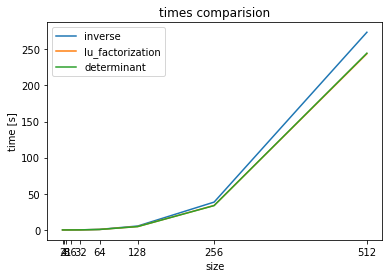

In [18]:
plt.plot(sizes, res_times)
plt.title("times comparision")
plt.xlabel("size")
plt.ylabel("time [s]")
plt.xticks(sizes)
plt.legend(("inverse", "lu_factorization", "determinant"))
plt.show()

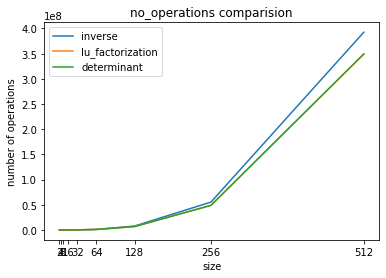

In [19]:
plt.plot(sizes, res_operations)
plt.title("no_operations comparision")
plt.xlabel("size")
plt.ylabel("number of operations")
plt.xticks(sizes)
plt.legend(("inverse", "lu_factorization", "determinant"))
plt.show()

# Złożoność

In [20]:
from scipy.optimize import curve_fit

In [39]:
def func(x, a, b):
    return a*np.power(x,b)

In [40]:
x_data = sizes
y_det_op = res_operations[:, 2]
y_lu_op = res_operations[:, 1]
y_inv_op = res_operations[:, 0]

y_det_time = res_times[:, 2]
y_lu_time = res_times[:, 1]
y_inv_time = res_times[:, 0]

-------------------------
### Inverse

In [66]:
params_inv_op, cov_inv_op = curve_fit(func, x_data, y_inv_op)
print(params_inv_op, "\n",  cov_inv_op)

[8.56451881 2.82776616] 
 [[ 2.16219871e-03 -4.05500320e-05]
 [-4.05500320e-05  7.60673003e-07]]


In [42]:
params_inv_time, cov_inv_time = curve_fit(func, x_data, y_inv_time)
print(params_inv_time, "\n",  cov_inv_time)

[5.91927788e-06 2.82907797e+00] 
 [[ 6.19522855e-16 -1.68106910e-11]
 [-1.68106910e-11  4.56273022e-07]]


------------------------------------------------------------------------------------------------
### LU

In [43]:
params_lu_op, cov_lu_op = curve_fit(func, x_data, y_lu_op)
print(params_lu_op, "\n",  cov_lu_op)

[7.04643666 2.84033601] 
 [[ 3.58794008e-03 -8.17822318e-05]
 [-8.17822318e-05  1.86458391e-06]]


In [44]:
params_lu_time, cov_lu_time = curve_fit(func, x_data, y_lu_time)
print(params_lu_time, "\n",  cov_lu_time)

[4.64791955e-06 2.84938080e+00] 
 [[ 7.22723284e-17 -2.49738771e-12]
 [-2.49738771e-12  8.63192528e-08]]


-------------------------------------------
### det

In [45]:
params_det_op, cov_det_op = curve_fit(func, x_data, y_det_op)
print(params_det_op, "\n", cov_det_op)

[7.04699003 2.84032389] 
 [[ 3.57877289e-03 -8.15668759e-05]
 [-8.15668759e-05  1.85952799e-06]]


In [46]:
params_det_time, cov_det_time = curve_fit(func, x_data, y_det_time)
print(params_det_time, "\n",  cov_det_time)

[4.35673758e-06 2.86025863e+00] 
 [[ 3.47608212e-16 -1.28141071e-11]
 [-1.28141071e-11  4.72490156e-07]]
